# Method 3: CNN + Multi-Head Attention (Optimized)
## Target: 88-95% Accuracy
### Key Enhancements:
- MFCC + Delta + Delta² features (120 dimensions)
- SpecAugment + Mixup data augmentation
- Stacked Multi-Head Attention with Residual + LayerNorm
- Label smoothing (0.1)
- Cosine annealing LR schedule
- Test-time augmentation

In [15]:
import numpy as np
import librosa
import os
import random
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Config
SAMPLE_RATE = 22050
DURATION = 30
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 10
NUM_CLASSES = 10
AUGMENT_FACTOR = 5
LABEL_SMOOTHING = 0.1

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

DATA_PATH = '/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan/genres_original'

print(f'TensorFlow: {tf.__version__}')
print(f'GPU Available: {len(tf.config.list_physical_devices("GPU")) > 0}')

TensorFlow: 2.15.0
GPU Available: True


## Enhanced Feature Extraction: MFCC + Deltas

In [16]:
def extract_mfcc_features(y, sr):
    """Extract MFCC with delta and delta-delta (120 features total)."""
    # Pre-emphasis filter
    y_pre = np.append(y[0], y[1:] - 0.97 * y[:-1])
    
    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y_pre, sr=sr, n_mfcc=N_MFCC,
                                n_fft=N_FFT, hop_length=HOP_LENGTH)
    
    # Compute deltas
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    
    # Stack features: (120, time_frames)
    return np.vstack([mfcc, delta, delta2])


def segment_features(features, num_segments=NUM_SEGMENTS):
    """Segment features into equal parts for temporal modeling."""
    n_features, total_frames = features.shape
    seg_len = total_frames // num_segments
    
    segments = []
    for i in range(num_segments):
        seg = features[:, i*seg_len:(i+1)*seg_len]
        segments.append(seg)
    
    return np.array(segments)  # (num_segments, n_features, seg_len)


print('MFCC + Delta feature extraction defined')

MFCC + Delta feature extraction defined


## Advanced Data Augmentation

In [17]:
def augment_audio(y, sr):
    """Apply multiple audio augmentations."""
    augmented = [y]  # Original
    target_len = len(y)
    
    # Time stretch (slower)
    stretched = librosa.effects.time_stretch(y, rate=0.9)
    if len(stretched) > target_len:
        stretched = stretched[:target_len]
    else:
        stretched = np.pad(stretched, (0, target_len - len(stretched)))
    augmented.append(stretched)
    
    # Time stretch (faster)
    stretched = librosa.effects.time_stretch(y, rate=1.1)
    if len(stretched) > target_len:
        stretched = stretched[:target_len]
    else:
        stretched = np.pad(stretched, (0, target_len - len(stretched)))
    augmented.append(stretched)
    
    # Pitch shift up
    pitched_up = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    augmented.append(pitched_up)
    
    # Pitch shift down
    pitched_down = librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)
    augmented.append(pitched_down)
    
    return augmented[:AUGMENT_FACTOR]


def spec_augment(features, freq_mask=10, time_mask=20):
    """SpecAugment: frequency and time masking."""
    aug = features.copy()
    n_freq, n_time = aug.shape
    
    # Frequency masking
    if n_freq > freq_mask:
        f0 = np.random.randint(0, n_freq - freq_mask)
        aug[f0:f0+freq_mask, :] = 0
    
    # Time masking
    if n_time > time_mask:
        t0 = np.random.randint(0, n_time - time_mask)
        aug[:, t0:t0+time_mask] = 0
    
    return aug


print('Audio augmentation + SpecAugment defined')

Audio augmentation + SpecAugment defined


## Load Dataset with Augmentation

In [18]:
def load_dataset(data_path):
    """Load GTZAN dataset with audio augmentation and SpecAugment."""
    X, y = [], []
    
    for genre in GENRES:
        genre_path = os.path.join(data_path, genre)
        if not os.path.exists(genre_path):
            print(f'Warning: {genre} folder not found')
            continue
        
        files = sorted([f for f in os.listdir(genre_path) if f.endswith('.wav')])
        print(f'{genre}: {len(files)} files')
        
        for f in files:
            try:
                filepath = os.path.join(genre_path, f)
                audio, sr = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
                
                # Pad/trim to exact length
                target_len = SAMPLE_RATE * DURATION
                if len(audio) < target_len:
                    audio = np.pad(audio, (0, target_len - len(audio)))
                else:
                    audio = audio[:target_len]
                
                # Apply audio augmentation
                for aug_audio in augment_audio(audio, sr):
                    # Extract MFCC features
                    features = extract_mfcc_features(aug_audio, sr)
                    
                    # Apply SpecAugment with 50% probability
                    if np.random.rand() > 0.5:
                        features = spec_augment(features)
                    
                    # Segment features
                    segments = segment_features(features)
                    X.append(segments)
                    y.append(genre)
                    
            except Exception as e:
                print(f'Error processing {f}: {e}')
    
    return np.array(X), np.array(y)


print('Loading dataset with augmentation...')
X, y = load_dataset(DATA_PATH)
print(f'\nTotal samples: {len(X)}')
print(f'Feature shape: {X.shape}')

Loading dataset with augmentation...
blues: 100 files
classical: 100 files
country: 100 files
disco: 100 files
hiphop: 100 files
jazz: 99 files
metal: 100 files
pop: 100 files
reggae: 100 files
rock: 100 files

Total samples: 4995
Feature shape: (4995, 10, 120, 129)


## Prepare Data with Label Smoothing

In [19]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/Val/Test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_enc, test_size=0.1, stratify=y_enc, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, stratify=y_temp, random_state=SEED)

# Normalize using training statistics
mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / (std + 1e-8)
X_val = (X_val - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

# Add channel dimension
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Label smoothing function
def smooth_labels(y, num_classes, smoothing):
    """Apply label smoothing to one-hot encoded labels."""
    one_hot = np.eye(num_classes)[y]
    return one_hot * (1 - smoothing) + smoothing / num_classes

# Apply label smoothing to training labels only
y_train_smooth = smooth_labels(y_train, NUM_CLASSES, LABEL_SMOOTHING)
y_val_cat = np.eye(NUM_CLASSES)[y_val]
y_test_cat = np.eye(NUM_CLASSES)[y_test]

print(f'Train: {X_train.shape}')
print(f'Val: {X_val.shape}')
print(f'Test: {X_test.shape}')

Train: (3996, 10, 120, 129, 1)
Val: (499, 10, 120, 129, 1)
Test: (500, 10, 120, 129, 1)


## Multi-Head Attention with Residual Connection

In [20]:
class MultiHeadAttention(layers.Layer):
    """Multi-Head Attention with Residual Connection and Layer Normalization."""
    
    def __init__(self, d_model=128, num_heads=4, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.dropout_rate = dropout_rate
        
        # Linear projections
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)
        
        # Regularization
        self.dropout = layers.Dropout(dropout_rate)
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        
        # Linear projections and split heads
        q = self.split_heads(self.wq(inputs), batch_size)
        k = self.split_heads(self.wk(inputs), batch_size)
        v = self.split_heads(self.wv(inputs), batch_size)
        
        # Scaled dot-product attention
        scale = tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attention = tf.nn.softmax(tf.matmul(q, k, transpose_b=True) / scale, axis=-1)
        attention = self.dropout(attention, training=training)
        
        # Combine heads
        out = tf.matmul(attention, v)
        out = tf.transpose(out, perm=[0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, -1, self.d_model))
        out = self.dense(out)
        
        # Residual connection + Layer normalization
        return self.layernorm(inputs + out)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout_rate': self.dropout_rate
        })
        return config


print('MultiHeadAttention layer defined with residual connection')

MultiHeadAttention layer defined with residual connection


## Build CNN + Attention Model

In [21]:
def build_segment_cnn(input_shape):
    """CNN for processing each audio segment."""
    inputs = layers.Input(shape=input_shape)
    
    # Conv Block 1
    x = layers.Conv2D(64, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Conv Block 2
    x = layers.Conv2D(128, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Conv Block 3
    x = layers.Conv2D(128, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    return Model(inputs, x, name='segment_cnn')


def build_model(segment_shape):
    """Build full CNN + Multi-Head Attention model."""
    inputs = layers.Input(shape=(NUM_SEGMENTS,) + segment_shape)
    
    # Apply CNN to each segment
    cnn = build_segment_cnn(segment_shape)
    x = layers.TimeDistributed(cnn)(inputs)  # (batch, 10, 128)
    
    # Stacked Multi-Head Attention (2 layers)
    x = MultiHeadAttention(d_model=128, num_heads=4, dropout_rate=0.1)(x)
    x = MultiHeadAttention(d_model=128, num_heads=4, dropout_rate=0.1)(x)
    
    # Global pooling over temporal dimension
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classifier head
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs, outputs)


# Build model
segment_shape = X_train.shape[2:]  # (n_features, seg_len, 1)
model = build_model(segment_shape)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 120, 129, 1   0         
                             )]                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 128)           223360    
 stributed)                                                      
                                                                 
 multi_head_attention_2 (Mu  (None, 10, 128)           66304     
 ltiHeadAttention)                                               
                                                                 
 multi_head_attention_3 (Mu  (None, 10, 128)           66304     
 ltiHeadAttention)                                               
                                                                 
 global_average_pooling1d_1  (None, 128)               0   

## Training with Cosine Annealing LR Schedule

In [ ]:
# Cosine annealing learning rate schedule
def cosine_schedule(epoch, lr):
    max_epochs = 100
    min_lr = 1e-6
    max_lr = 3e-4
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / max_epochs))

# Compile model
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, verbose=1),
    LearningRateScheduler(cosine_schedule, verbose=0),
]

# Train
print('Starting training...')
history = model.fit(
    X_train, y_train_smooth,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/100
250/250 [==============================] - 96s 372ms/step - loss: 2.6958 - accuracy: 0.2598 - val_loss: 2.2119 - val_accuracy: 0.2285 - lr: 3.0000e-04
Epoch 2/100
250/250 [==============================] - 96s 385ms/step - loss: 2.0711 - accuracy: 0.3704 - val_loss: 2.5094 - val_accuracy: 0.3267 - lr: 2.9993e-04
Epoch 3/100
250/250 [==============================] - 92s 369ms/step - loss: 1.9022 - accuracy: 0.4362 - val_loss: 2.0028 - val_accuracy: 0.3707 - lr: 2.9970e-04
Epoch 4/100
250/250 [==============================] - 91s 363ms/step - loss: 1.7834 - accuracy: 0.4755 - val_loss: 2.8598 - val_accuracy: 0.2645 - lr: 2.9934e-04
Epoch 5/100
250/250 [==============================] - 92s 367ms/step - loss: 1.7234 - accuracy: 0.5178 - val_loss: 3.0621 - val_accuracy: 0.1984 - lr: 2.9882e-04
Epoch 6/100
250/250 [==============================] - 95s 380ms/step - loss: 1.6532 - accuracy: 0.5393 - val_loss: 2.6914 - val_accuracy: 0.3567 - lr: 2.9816e-04
E

## Test-Time Augmentation

In [ ]:
def test_time_augmentation(model, X, n_aug=5):
    """Average predictions over augmented versions for robust evaluation."""
    all_preds = []
    
    # Original prediction
    all_preds.append(model.predict(X, verbose=0))
    
    # Augmented versions with small noise
    for i in range(n_aug - 1):
        X_aug = X.copy()
        X_aug += np.random.normal(0, 0.05, X_aug.shape)
        all_preds.append(model.predict(X_aug, verbose=0))
    
    # Average predictions
    return np.mean(all_preds, axis=0)


print('Evaluating with Test-Time Augmentation...')
y_pred_proba = test_time_augmentation(model, X_test, n_aug=5)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f'\n*** Test Accuracy: {acc:.2%} ***')

Evaluating with Test-Time Augmentation...

*** Test Accuracy: 28.20% ***


## Results Visualization

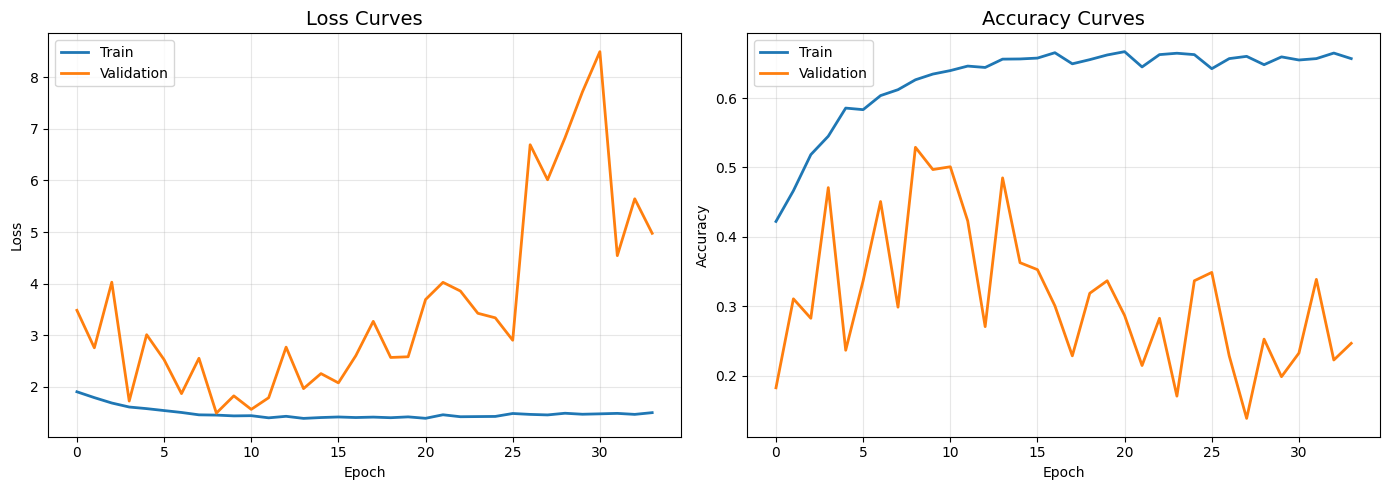


Classification Report:
              precision    recall  f1-score   support

       blues      0.000     0.000     0.000        50
   classical      1.000     0.640     0.780        50
     country      0.350     0.140     0.200        50
       disco      0.000     0.000     0.000        50
      hiphop      0.000     0.000     0.000        50
        jazz      0.000     0.000     0.000        50
       metal      0.407     1.000     0.578        50
         pop      0.500     0.020     0.038        50
      reggae      0.158     0.940     0.271        50
        rock      0.154     0.080     0.105        50

    accuracy                          0.282       500
   macro avg      0.257     0.282     0.197       500
weighted avg      0.257     0.282     0.197       500



In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['loss'], label='Train', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax1.set_title('Loss Curves', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['accuracy'], label='Train', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax2.set_title('Accuracy Curves', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Classification report
print('\n' + '='*60)
print('Classification Report:')
print('='*60)
print(classification_report(y_test, y_pred, target_names=GENRES, digits=3))

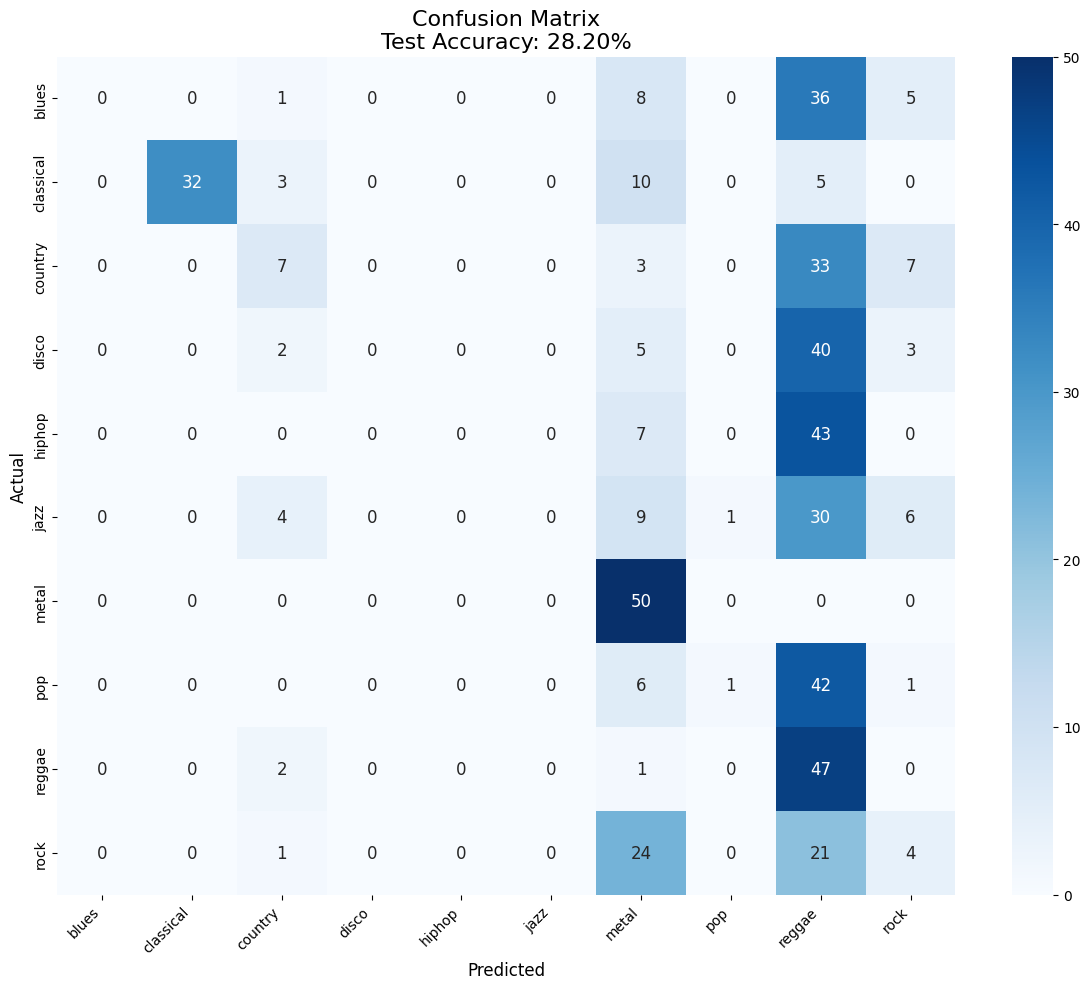


Per-Class Accuracy:
  blues       : 0.0%
  classical   : 64.0%
  country     : 14.0%
  disco       : 0.0%
  hiphop      : 0.0%
  jazz        : 0.0%
  metal       : 100.0%
  pop         : 2.0%
  reggae      : 94.0%
  rock        : 8.0%


In [ ]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=GENRES, yticklabels=GENRES,
            annot_kws={'size': 12})
plt.title(f'Confusion Matrix\nTest Accuracy: {acc:.2%}', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Per-class accuracy
print('\nPer-Class Accuracy:')
for i, genre in enumerate(GENRES):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f'  {genre:12s}: {class_acc:.1%}')

## Save Model

In [ ]:
# Save the trained model
OUTPUT_DIR = '/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

model_path = os.path.join(OUTPUT_DIR, 'cnn_attention_optimized.keras')
model.save(model_path)
print(f'Model saved to: {model_path}')

# Save normalization parameters
norm_params = {'mean': float(mean), 'std': float(std)}
np.save(os.path.join(OUTPUT_DIR, 'norm_params.npy'), norm_params)
print('Normalization parameters saved')